In [55]:
# 1. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# 2. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# 3. 파일 경로 설정 (내 Drive 경로로 수정하세요)
base_path = '/content/drive/MyDrive/전력예측데이터/'

power = pd.read_csv(base_path + '전국평균전력사용량.csv', encoding='cp949')
population = pd.read_csv(base_path + '주민등록인구및세대현황.csv', encoding='cp949')
factory = pd.read_csv(base_path + '공장등록수.csv', encoding='cp949')
temperature = pd.read_csv(base_path + '기온.csv', encoding='utf-8-sig')

# 데이터 확인
print("데이터 형태 확인:")
print(f"전력: {power.shape}, 인구: {population.shape}, 공장: {factory.shape}, 기온: {temperature.shape}")

데이터 형태 확인:
전력: (850, 6), 인구: (850, 8), 공장: (851, 4), 기온: (510, 6)


In [67]:
# 4. 병합
keys = ['지역명', '연', '월']

# 병합 전 각 데이터프레임의 키 컬럼 확인
print("각 데이터프레임의 키 컬럼 확인:")
for name, data in [('power', power), ('population', population), ('factory', factory), ('temperature', temperature)]:
    print(f"{name}: {[col for col in keys if col in data.columns]}")
    if '지역명' in data.columns:
        print(f"  지역명 샘플: {data['지역명'].unique()[:5]}")

df = power.merge(population, on=keys, how='inner')
print(f"전력 + 인구 병합 후: {df.shape}")

df = df.merge(factory, on=keys, how='inner')
print(f"+ 공장 병합 후: {df.shape}")

df = df.merge(temperature, on=keys, how='inner')
print(f"+ 기온 병합 후: {df.shape}")

# 병합 후 데이터 확인
print(f"\n병합 후 컬럼들: {df.columns.tolist()}")
print(f"지역명 고유값: {df['지역명'].nunique()}개")
print(f"연도 범위: {df['연'].min()} ~ {df['연'].max()}")

# 지역명 보존 (get_dummies 전에!)
df['지역명_원본'] = df['지역명'].copy()

각 데이터프레임의 키 컬럼 확인:
power: ['지역명', '연', '월']
  지역명 샘플: ['강원도' '경기도' '경상남도' '경상북도' '광주광역시']
population: ['지역명', '연', '월']
  지역명 샘플: ['강원도' '경기도' '경상남도' '경상북도' '광주광역시']
factory: ['지역명', '연', '월']
  지역명 샘플: ['강원도' '경기도' '경상남도' '경상북도' '광주광역시']
temperature: ['지역명', '연', '월']
  지역명 샘플: ['강원도' '경기도' '경상남도' '경상북도' '광주광역시']
전력 + 인구 병합 후: (850, 11)
+ 공장 병합 후: (850, 12)
+ 기온 병합 후: (510, 15)

병합 후 컬럼들: ['지역명', '연', '월', '대상가구수', '평균사용량', '평균금액', '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '등록공장수', '평균기온', '평균최저기온', '평균최고기온']
지역명 고유값: 17개
연도 범위: 2020 ~ 2024


In [68]:
# 5. 파생 변수 생성
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df['계절'] = df['월'].apply(get_season)

# 세대당 인구 컬럼이 있는지 확인하고 처리
if '세대당 인구' in df.columns:
    df['세대당 인구'] = pd.to_numeric(df['세대당 인구'], errors='coerce')
else:
    # 세대당 인구가 없다면 총인구수/세대수로 계산
    df['세대당 인구'] = df['총인구수'] / df['세대수']

# 결측값 처리
df = df.fillna(df.mean(numeric_only=True))

In [69]:
# 6. 범주형 변수 처리
print("범주형 변수 처리 전 컬럼들:")
print(df.columns.tolist())

df = pd.get_dummies(df, columns=['계절', '지역명'], drop_first=True)

print("범주형 변수 처리 후 컬럼들:")
print(df.columns.tolist())

범주형 변수 처리 전 컬럼들:
['지역명', '연', '월', '대상가구수', '평균사용량', '평균금액', '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '등록공장수', '평균기온', '평균최저기온', '평균최고기온', '지역명_원본', '계절']
범주형 변수 처리 후 컬럼들:
['연', '월', '대상가구수', '평균사용량', '평균금액', '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '등록공장수', '평균기온', '평균최저기온', '평균최고기온', '지역명_원본', '계절_spring', '계절_summer', '계절_winter', '지역명_경기도', '지역명_경상남도', '지역명_경상북도', '지역명_광주광역시', '지역명_대구광역시', '지역명_대전광역시', '지역명_부산광역시', '지역명_서울특별시', '지역명_세종특별자치시', '지역명_울산광역시', '지역명_인천광역시', '지역명_전라남도', '지역명_전라북도', '지역명_제주특별자치도', '지역명_충청남도', '지역명_충청북도']


In [70]:
# 7. 특성과 타깃 분리
# 숫자형 컬럼만 선택
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"숫자형 컬럼들: {numeric_columns}")

# 타깃 변수 제거
if '평균사용량' in numeric_columns:
    numeric_columns.remove('평균사용량')

# 사용하고 싶지 않은 컬럼들 제거 (ID, 원본 지역명 등)
exclude_columns = ['지역명_원본']
features = [col for col in numeric_columns if col not in exclude_columns]

print(f"사용할 특성들: {features}")

# 데이터 타입 확인 및 변환
X = df[features].copy()
y = df['평균사용량'].copy()

# 문자열이 섞여있는지 확인
print("각 컬럼의 데이터 타입:")
for col in X.columns:
    print(f"{col}: {X[col].dtype}")
    if X[col].dtype == 'object':
        print(f"  -> {col} 컬럼에 문자열 데이터가 있습니다: {X[col].unique()[:5]}")

# 모든 특성을 숫자형으로 변환
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# 변환 후 결측값 처리
X = X.fillna(X.mean())
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(y.mean())

print(f"최종 특성 데이터 형태: {X.shape}")
print(f"최종 타깃 데이터 형태: {y.shape}")
print(f"결측값 확인 - X: {X.isnull().sum().sum()}, y: {y.isnull().sum()}")


숫자형 컬럼들: ['연', '월', '대상가구수', '평균사용량', '평균금액', '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '등록공장수', '평균기온', '평균최저기온', '평균최고기온']
사용할 특성들: ['연', '월', '대상가구수', '평균금액', '총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '등록공장수', '평균기온', '평균최저기온', '평균최고기온']
각 컬럼의 데이터 타입:
연: int64
월: int64
대상가구수: int64
평균금액: int64
총인구수: int64
세대수: int64
세대당 인구: float64
남자 인구수: int64
여자 인구수: int64
등록공장수: int64
평균기온: float64
평균최저기온: float64
평균최고기온: float64
최종 특성 데이터 형태: (510, 13)
최종 타깃 데이터 형태: (510,)
결측값 확인 - X: 0, y: 0


In [71]:
# 8. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [72]:
# 9. 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [75]:
# 10. 예측 및 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"📊 MAE: {mae:.4f}")
print(f"📉 RMSE: {rmse:.4f}")

📊 MAE: 5.7936
📉 RMSE: 9.0715


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

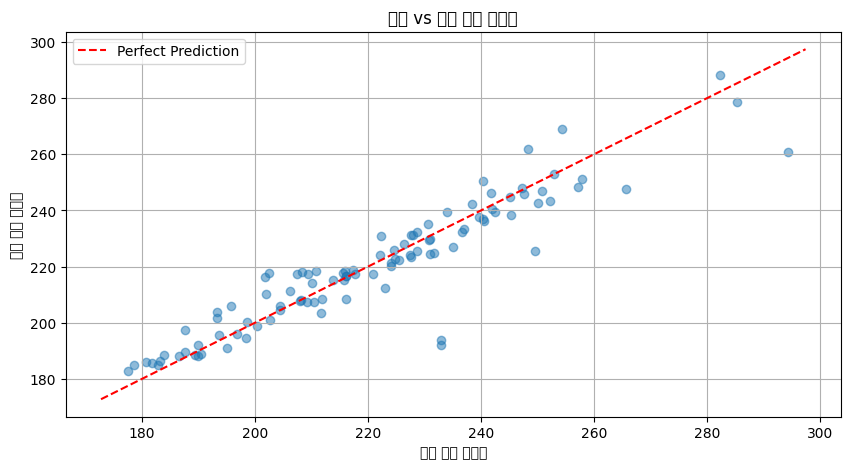

In [76]:
# 11. 예측 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')
plt.xlabel("실제 전력 사용량")
plt.ylabel("예측 전력 사용량")
plt.title("예측 vs 실제 전력 사용량")
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# 12. 2024년 2월 데이터 예측 (데이터가 있는 경우)
future_data = df[(df['연'] == 2024) & (df['월'] == 2)]

if len(future_data) > 0:
    future_X = future_data[features]
    future_pred = model.predict(future_X)

    # 13. 예측 결과 출력
    future_result = future_data[['지역명_원본', '연', '월']].copy()
    future_result.rename(columns={'지역명_원본': '지역명'}, inplace=True)
    future_result['예측 전력 사용량'] = future_pred

    print("\n🔮 2024년 2월 지역별 전력 사용량 예측")
    print(future_result.sort_values(by='예측 전력 사용량', ascending=False).reset_index(drop=True))
else:
    print("\n⚠️ 2024년 2월 데이터가 없습니다.")
    print("대신 가장 최근 데이터로 예측을 수행합니다.")

    # 가장 최근 연도와 월 찾기
    latest_year = df['연'].max()
    latest_month = df[df['연'] == latest_year]['월'].max()

    latest_data = df[(df['연'] == latest_year) & (df['월'] == latest_month)]
    latest_X = latest_data[features]
    latest_pred = model.predict(latest_X)

    latest_result = latest_data[['지역명_원본', '연', '월']].copy()
    latest_result.rename(columns={'지역명_원본': '지역명'}, inplace=True)
    latest_result['예측 전력 사용량'] = latest_pred

    print(f"\n🔮 {latest_year}년 {latest_month}월 지역별 전력 사용량 예측")
    print(latest_result.sort_values(by='예측 전력 사용량', ascending=False).reset_index(drop=True))



🔮 2024년 2월 지역별 전력 사용량 예측
        지역명     연  월  예측 전력 사용량
0   세종특별자치시  2024  2   278.4191
1       경기도  2024  2   257.9683
2     인천광역시  2024  2   248.2697
3     울산광역시  2024  2   248.1245
4     대구광역시  2024  2   241.3852
5     부산광역시  2024  2   240.7560
6     광주광역시  2024  2   239.2243
7     대전광역시  2024  2   235.0256
8     서울특별시  2024  2   234.4453
9       강원도  2024  2   226.8679
10     충청북도  2024  2   220.5895
11     충청남도  2024  2   220.3101
12     전라북도  2024  2   218.4292
13     경상북도  2024  2   209.8667
14  제주특별자치도  2024  2   192.2373


<ipython-input-84-1415628736>:12: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-84-1415628736>:12: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8

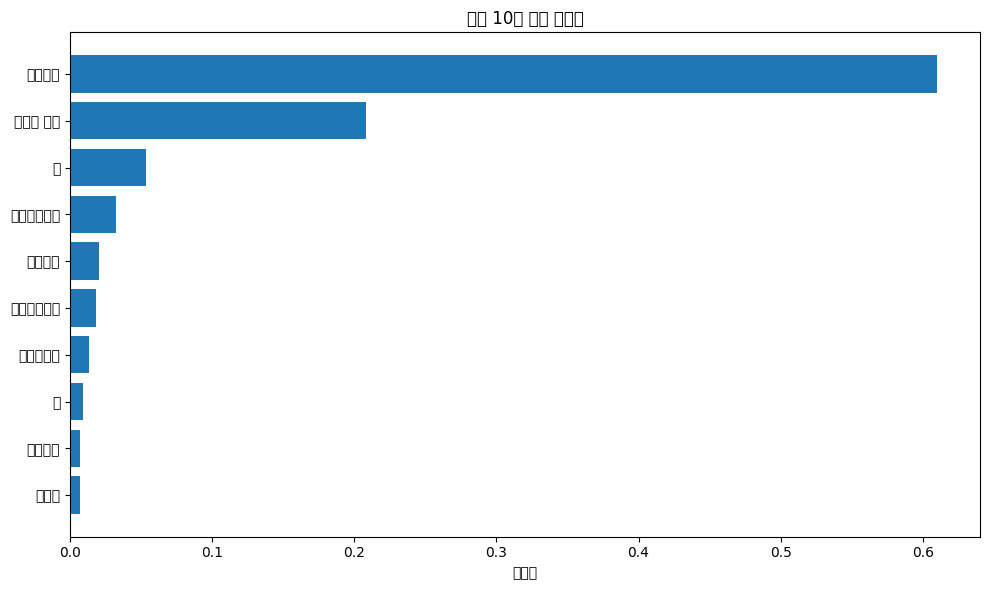


📈 상위 5개 중요 특성:
   feature  importance
3     평균금액    0.609733
6   세대당 인구    0.208373
0        연    0.053515
11  평균최저기온    0.032287
10    평균기온    0.020510


In [84]:
# 14. 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('중요도')
plt.title('상위 10개 특성 중요도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📈 상위 5개 중요 특성:")
print(feature_importance.head())